<a href="https://colab.research.google.com/github/TAUforPython/Graph-MachineLearning/blob/main/Hyperbolic%20GNN%20for%20genomic%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Hyperbolic GNN + Poincaré Ball Visualization for Protein Sequences


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree
from scipy.spatial.distance import squareform, pdist
from scipy.stats import pearsonr
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


#Main code

In [2]:
# ============================================
# Step 1: Dataset - TP53 Protein Sequences
# ============================================

sequences_data = {
    'Human': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD',
    'Mouse': 'MTAMEESQSDISLELPLSQETFSGLWKLLPPEDILPSPHCMDDLLLPQDVEEFFEGPSEALRVSGAPAAQDPVTETPGPVAPAPATPWPLSSFVPSQKTYQGNYGFHLGFLQSGTAKSVMCTYSPPLNKLFCQLAKTCPVQLWVSATPPAGSRVRAMAIYKKSQHMTEVVRRCPHHERCSDGDGLAPPQHLIRVEGNLYPEYLEDRQTFRHSVVVPYEPPEAGSEYTTIHYKYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRDSFEVRVCACPGRDRRTEEENFRKKEVLCPELPPGSAKRALPTCTSASPPQKKKPLDGEYFTLKIRGRKRFEMFRELNEALELKDAHATEESGDSRAHSSYLKTKKGQSTSRHKKTMVKKVGPDSD',
    'Rat': 'MEDSQSDMSIELPLSQETFSCLWKLLPPDDILPTTATGSPNSMEDLFLPQDVAELLEGPEEALQVSAPAAQEPGTEAPAPVAPASATPWPLSSSVPSQKTYQGNYGFHLGFLQSGTAKSVMCTYSISLNKLFCQLAKTCPVQLWVTSTPPPGTRVRAMAIYKKSQHMTEVVRRCPHHERCSDGDGLAPPQHLIRVEGNPYAEYLDDRQTFRHSVVVPYEPPEVGSDYTTIHYKYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRDSFEVRVCACPGRDRRTEEENFRKKEEHCPELPPGSAKRALPTSTSSSPQQKKKPLDGEYFTLKIRGRERFEMFRELNEALELKDARAAEESGDSRAHSSYPKTKKGQSTSRHKKPMIKKVGPDSD',
    'Hamster': 'MEEPQSDLSIELPLSQETFSDLWKLLPPNNVLSTLPSSDSIEELFLSENVTGWLEDSGGALQGVAAAAASTAEDPVTETPAPVASAPATPWPLSSSVPSYKTYQGDYGFRLGFLHSGTAKSVTCTYSPSLNKLFCQLAKTCPVQLWVNSTPPPGTRVRAMAIYKKLQYMTEVVRRCPHHERSSEGDSLAPPQHLIRVEGNLHAEYLDDKQTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDPSGNLLGRNSFEVRICACPGRDRRTEEKNFQKKGEPCPELPPKSAKRALPTNTSSSPPPKKKTLDGEYFTLKIRGHERFKMFQELNEALELKDAQASKGSEDNGAHSSYLKSKKGQSASRLKKLMIKREGPDSD',
    'Dog': 'MEESQSELNIDPPLSQETFSELWNLLPENNVLSSELCPAVDELLLPESVVNWLDEDSDDAPRMPATSAPTAPGPAPSWPLSSSVPSPKTYPGTYGFRLGFLHSGTAKSVTWTYSPLLNKLFCQLAKTCPVQLWVSSPPPPNTCVRAMAIYKKSEFVTEVVRRCPHHERCSDSSDGLAPPQHLIRVEGNLRAKYLDDRNTFRHSVVVPYEPPEVGSDYTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNVLGRNSFEVRVCACPGRDRRTEEENFHKKGEPCPEPPPGSTKRALPPSTSSSPPQKKKPLDGEYFTLQIRGRERYEMFRNLNEALELKDAQSGKEPGGSRAHSSHLKAKKGQSTSRHKKLMFKREGLDSD',
    'Pig': 'MEESQSELGVEPPLSQETFSDLWKLLPENNLLSSELSLAAVNDLLLSPVTNWLDENPDDASRVPAPPAATAPAPAAPAPATSWPLSSFVPSQKTYPGSYDFRLGFLHSGTAKSVTCTYSPALNKLFCQLAKTCPVQLWVSSPPPPGTRVRAMAIYKKSEYMTEVVRRCPHHERSSDYSDGLAPPQHLIRVEGNLRAEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNFMCNSSCMGGMNRRPILTIITLEDASGNLLGRNSFEVRVCACPGRDRRTEEENFLKKGQSCPEPPPGSTKRALPTSTSSSPVQKKKPLDGEYFTLQIRGRERFEMFRELNDALELKDAQTARESGENRAHSSHLKSKKGQSPSRHKKPMFKREGPDSD',
    'Macaque': 'MEEPQSDPSIEPPLSQETFSDLWKLLPENNVLSPLPSQAVDDLMLSPDDLAQWLTEDPGPDEAPRMSEAAPPMAPTPAAPTPAAPAPAPSWPLSSSVPSQKTYHGSYGFRLGFLHSGTAKSVTCTYSPDLNKMFCQLAKTCPVQLWVDSTPPPGSRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYSDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENFRKKGEPCHQLPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPAGSRAHSSHLKSKKGQSTSRHKKFMFKTEGPDSD',
    'Whale': 'MEESQAELGVEPPLSQETFSDLWKLLPENNLLSSELSPAVDDLLLSPEDVANWLDERPDEAPQMPEPPAPAAPTPAAPAPATSWPLSSFVPSQKTYPGSYGFHLGFLHSGTAKSVTCTYSPALNKLFCQLAKTCPVQLWVSSPPPPGTRVRAMAIYKKSEYMTEVVRRCPHHERCSDYSDGLAPPQHLIRVEGNLRAEYL DDRNTFRHSVVVPYEPPEVGSDCTTIHYNFMCNSSCMGGMNRRPILTIITLEDSNGNLLGRNSFEVRVCACPGRDRRTEEENFHKKGQSCPELPTGSAKRALPTGTSSSPPQKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGESRAHSSHLKSKKGQSPSRHKKLMFKREGPDSD',
    'Bovine': 'MEESQAELNVEPPLSQETFSDLWNLLPENNLLSSELSAPVDDLLPYTDVATWLDECPNEAPQMPEPSAPAAPPPATPAPATSWPLSSFVPSQKTYPGNYGFRLGFLQSGTAKSVTCTYSPSLNKLFCQLAKTCPVQLWVDSPPPPGTRVRAMAIYKKLEHMTEVVRRCPHHERSSDYSDGLAPPQHLIRVEGNLRAEYLDDRNTFRHSVVVPYESPEIDSECTTIHYNFMCNSSCMGGMNRRPILTIITLEDSCGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGQSCPEPPPRSTKRALPTNTSSSPQPKKKPLDGEYFTLQIRGFKRYEMFRELNDALELKDALDGREPGESRAHSSHLKSKKRPSPSCHKKPMLKREGPDSD',
    'Monkey': 'MEEPQSDPSIEPPLSQETFSDLWKLLPENNVLSPLPSQAVDDLMLSPDDLAQWLTEDPGPDEAPRMSEAAPHMAPTPAAPTPAAPAPAPSWPLSSSVPSQKTYHGSYGFRLGFLHSGTAKSVTCTYSPDLNKMFCQLAKTCPVQLWVDSTPPPGSRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYSDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENFRKKGEPCHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPAGSRAHSSHLKSKKGQSTSRHKKFMFKTEGPDSD',
    'Cat': 'MQEPPLELTIEPPLSQETFSELWNLLPENNVLSSELSSAMNELPLSEDVANWLDEAPDDASGMSAVPAPAAPAPATPAPAISWPLSSFVPSQKTYPGAYGFHLGFLQSGTAKSVTCTYSPPLNKLFCQLAKTCPVQLWVRSPPPPGTCVRAMAIYKKSEFMTEVVRRCPHHERCPDSSDGLAPPQHLIRVEGNLHAKYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNFMCNSSCMGGMNRRPIITIITLEDSNGKLLGRNSFEVRVCACPGRDRRTEEENFRKKGEPCPEPPPGSTKRALPPSTSSTPPQKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQSGKEPGGSRAHSSHLKAKKGQSTSRHKKPMLKREGLDSD',
    'Woodchuck': 'MEEAQSDLSIEPPLSQETFSDLWNLLPENNVLSPVLSPPMDDLLLSSEDVENWFDKGPDEALQMSAAPAPKAPTPAASTLAAPSPATSWPLSSSVPSQNTYPGVYGFRLGFLHSGTAKSVTCTYSPSLNKLFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKKSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLR AEYLDDRNTFRHSVVVPYEPPEVGSECTTIHYNYMCNSSCMGGMNRRPILTIITLEGSSGNLLGRNSFEVRVCACPGRDRRTEEENFRKRGEPCPEPPPRSTKRALPNGTSSSPQPKKKPLDGEYFTLKIRGRARFEMFQELNEALELKDAQAEKEPGESRPHPSYLKSKKGQSTSRHKKIIFKREGPDSD',
    'Rabbit': 'MEESQSDLSLEPPLSQETFSDLWKLLPENNLLTTSLNPPVDDLLSAEDVANWLNEDPEEGLRVPAAPAPEAPAPAAPALAAPAPATSWPLSSSVPSQKTYHGNYGFRLGFLHSGTAKSVTCTYSPCLNKLFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKKSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRAEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENFRKKGEPCPELPPGSSKRALPTTTTDSSPQTKKKPLDGEYFILKIRGRERFEMFRELNEALELKDAQAEKEPGGSRAHSSYLKAKKGQSTSRHKKPMFKREGPDSD',
    'Guinea-pig': 'MEEPHSDLSIEPPLSQETFSDLWKLLPENNVLSDSLSPPMDHLLLSPEEVASWLGENPDGDGHVSAAPVSEAPTSAGPALVAPAPATSWPLSSSVPSHKPYRGSYGFEVHFLKSGTAKSVTCTYSPGLNKLFCQLAKTCPVQVWVESPPPPGTRVRALAIYKKSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLHAEYVDDRTTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGKLLGRDSFEVRVCACPGRDRRTEEENFRKKGGLCPEPTPGNIKRALPTSTSSSPQPKKKPLDAEYFTLKIRGRKNFEILREINEALEFKDAQTEKEPGESRPHSSYPKSKKGQSTSCHKKLMFKREGLDSD',
    'Sheep': 'MEESQAELGVEPPLSQETFSDLWNLLPENNLLSSELSAPVDDLLPYSEDVVTWLDECPNEAPQMPEPPAQAALAPATSWPLSSFVPSQKTYPGNYGFRLGFLHSGTAKSVTCTYSPSLNKLFCQLAKTCPVQLWVDSPPPPGTRVRAMAIYKKLEHMTEVVRRSPHHERSSDYSDGLAPPQHLIRVEGNLRAEYFDDRNTFRHSVVVPYESPEIESECTTIHYNFMCNSSCMGGMNRRPILTIITLEDSRGNLLGRSSFEVRVCACPGRDRRTEEENFRKKGQSCPEPPPGSTKRALPSSTSSSPQQKKKPLDGEYFTLQIRGRKRFEMFRELNEALELMDAQAGREPGESRAHSSHLKSKKGPSPSCHKKPMLKREGPDSD',
    'Zebrafish': 'MAQNDSQEFAELWEKNLIIQPPGGGSCWDIINDEEYLPGSFDPNFFENVLEEQPQPSTLPPTSTVPETSDYPGDHGFRLRFPQSGTAKSVTCTYSPDLNKLFCQLAKTCPVQMVVDVAPPQGSVVRATAIYKKSEHVAEVVRRCPHHERTPDGDNLAPAGHLIRVEGNQRANYREDNITLRHSVFVPYEAPQLGAEWTTVLLNYMCNSSCMGGMNRRPILTIITLETQEGQLLGRRSFEVRVCACPGRDRKTEESNFKKDQETKTMAKTTTGTKRSLVKESSSATLRPEGSKKAKGSSSDEEIFTLQVRGRERYEILKKLNDSLELSDVVPASDAEKYRQKFMTKNKKENRESSEPKQGKKLMVKDEGRSDSD',
    'Rice fish': 'MDPVPDLPESQGSFQELWETVSYPPLETLSLPTVNEPTGSWVATGDMFLLDQDLSGTFDDKIFDIPIEPVPTNEVNPPPTTVPVTTDYPGSYELELRFQKSGTAKSVTSTYSETLNKLYCQLAKTSPIEVRVSKEPPKGAILRATAVYKKTEHVADVVRRCPHHQNEDSVEHRSHLIRVEGSQLAQYFEDPYTKRQSVTVPYEPPQPGSEMTTILLSYMCNSSCMGGMNRRPILTILTLETEGLVLGRRCFEVRICACPGRDRKTEEESRQKTQPKKRKVTPNTSSSKRKKSHSSGEEEDNREVFHFEVYGRERYEFLKKINDGLELLEKESKSKNKDSGMVPSSGKKLKSN',
    'Catfish': 'MEGNGERDTMMVEPPDSQEFAELWLRNLIVRDNSLWGKEEEIPDDLQEVPCDVLLSDMLQPQSSSSPPTSTVPVTSDYPGLLNFTLHFQESSGTKSVTCTYSPDLNKLFCQLAKTCPVLMAVSSSPPPGSVLRATAVYKRSEHVAEVVRRCPHHERSNDSSDGPAPPGHLLRVEGNSRAVYQEDGNTQAHSVVVPYEPPQVGSQSTTVLYNYMCNSSCMGGMNRRPILTIITLETQDGHLLGRRTFEVRVCACPGRDRKTEESNFKKQQEPKTSGKTLTKRSMKDPPSHPEASKKSKNSSSDDEIYTLQVRGKERYEFLKKINDGLELSDVVPPADQEKYRQKLLSKTCRKERDGAAGEPKRGKKRLVKEEKCDSD',
    'Trout': 'MADLAENVSLPLSQESFEDLWKMNLNLVAVQPPETESWVGYDNFMMEAPLQVEFDPSLFEVSATEPAPQPSISTLDTGSPPTSTVPTTSDYPGALGFQLRFLQSSTAKSVTCTYSPDLNKLFCQLAKTCPVQIVVDHPPPPGAVVRALAIYKKLSDVADVVRRCPHHQSTSENNEGPAPRGHLVRVEGNQRSEYMEDGNTLRHSVLVPYEPPQVGSECTTVLYNFMCNSSCMGGMNRRPILTIITLETQEGQLLGRRSFEVRVCACPGRDRKTEEINLKKQQETTLETKTKPAQGIKRAMKEASLPAPQPGASKKTKSSPAVSDDEIYTLQIRGKEKYEMLKKFNDSLELSELVPVADADKYRQKCLTKRVAKRDFGVGPKKRKKLLVKEEKSDSD',
    'Barbel': 'MAESQEFAELWERNLISTQEAGTCWELINDEYLPSSFDPNIFDNVLTEQPQPSTSPPTASVPVATDYPGEHGFKLGFPQSGTAKSVTCTYSSDLNKLFCQLAKTCPVQMVVNVAPPQGSVIRATAIYKKSEHVAEVVRRCPHHERTPDGDGLAPAAHLIRVEGNSRALYREDDVNSRHSVVVPYEVPQLGSEFTTVLYNFMCNSSCMGGMNRRPILTIISLETHDGQLLGRRSFEVRVCACPGRDRKTEESNFRKDQETKTLDKIPSANKRSLTKDSTSSVPRPEGSKKAKLSGSSDEEIYTLQVRGKERYEMLKKINDSLELSDVVPPSEMDRYRQKLLTKGKKKDGQTPEPKRGKKLMVKDEKSDSD',
    'Frog': 'MEPSSETGMDPPLSQETFEDLWSLLPDPLQTVTCRLDNLSEFPDYPLAADMTVLQEGLMGNAVPTVTSCAVPSTDDYAGKYGLQLDFQQNGTAKSVTCTYSPELNKLFCQLAKTCPLLVRVESPPPRGSILRATAVYKKSEHVAEVVKRCPHHERSVEPGEDAAPPSHLMRVEGNLQAYYMEDVNSGRHSVCVPYEGPQVGTECTTVLYNYMCNSSCMGGMNRRPILTIITLETPQGLLLGRRCFEVRVCACPGRDRRTEEDNYTKKRGLKPSGKRELAHPPSSEPPLPKKRLVVVDDDEEIFTLRIKGRSRYEMIKKLNDALELQESLDQQKVTIKCRKCRDEIKPKKGKKLLVKDEQPDSE',
    'Chicken': 'MAEEMEPLLEPTEVFMDLWSMLPYSMQQLPLPEDHSNWQELSPLEPSDPPPPPPPPPLPLAAAAPPPLNPPTPPRAAPSPVVPSTEDYGGDFDFRVGFVEAGTAKSVTCTYSPVLNKVYCRLAKPCPVQVRVGVAPPPGSSLRAVAVYKKSEHVAEVVRRCPHHERCGGGTDGLAPAQHLIRVEGNPQARYHDDETTKRHSVVVPYEPPEVGSDCTTVLYNFMCNSSCMGGMNRRPILTILTLEGPGGQLLGRRCFEVRVCACPGRDRKIEEENFRKRGGAGGVAKRAMSPPTEAPEPPKKRVLNPDNEIFYLQVRGRRRYEMLKEINEALQLAEGGSAPRPSKGRRVKVEGPQPSCGKKLLQKGSD',
    'Platyfish': 'MEEADLTLPLSQDTFHDLWNNVFLSTENESLPPPEGLLSQNMDFWEDPETMQETKNVPTAPTVPAISNYAGEHGFNLEFNDSGTAKSVTSTYSVKLGKLFCQLAKTTPIGVLVKEEPPQGAVIRATAVYKKTEHVGEVVKRCPHHQSEDLSDNKSHLIRVEGSQLAQYFEDPNTRRHSVTVPYERPQLGSEMTTILLSFM CNSSCMGGMNRRPILTILTLETTEGEVLGRRCFEVRVCACPGRDRKTEEGNLEKSGTKQTKKRKSAPAPDTSTAKKSKSASSGEDEDKEIYTLSIRGRNRYLWFKSLNDGLELMDKTGPKIKQEIPAPSSGKRLLKGGSDSD',
    'Flounder': 'MMDEQGLDGMQILPGSQDSFSELWASVQTPSIATIAEEFDDHLGNLLQNGFDMNLFELPPEMVAKDSVTPPSSTVPVVTDYPGEYGFQLRFQKSGTAKSVTSTFSELLKKLYCQLAKTSPVEVLLSKEPPQGAVLRATAVYKKTEHVADVVRRCPHHQTEDTAEHRSHLIRLEGSQRALYFEDPHTKRQSVTVPYEPPQLGSETTAILLSFMCNSSCMGGMNRRQILTILTLETPDGLVLGRRCFEVRVCACPGRDRKTDEESSTKTPNGPKQTKKRKQAPSNSAPHTTTVMKSKSSSSAEEEDKEVFTVLVKGRERYEIIKKINEAFEGAAEKEKAKNKVAVKQELPVPSSGKRLVQRGERSDSD'
}

# Create DataFrame
species = list(sequences_data.keys())
sequences = list(sequences_data.values())

df = pd.DataFrame({
    'species': species,
    'sequence': sequences
})

print(f"Dataset loaded: {len(df)} species")
print(f"Sequence length range: {df['sequence'].str.len().min()} - {df['sequence'].str.len().max()}")
print("\nSpecies list:")
for i, sp in enumerate(species, 1):
    print(f"{i:2d}. {sp}")

Dataset loaded: 24 species
Sequence length range: 343 - 396

Species list:
 1. Human
 2. Mouse
 3. Rat
 4. Hamster
 5. Dog
 6. Pig
 7. Macaque
 8. Whale
 9. Bovine
10. Monkey
11. Cat
12. Woodchuck
13. Rabbit
14. Guinea-pig
15. Sheep
16. Zebrafish
17. Rice fish
18. Catfish
19. Trout
20. Barbel
21. Frog
22. Chicken
23. Platyfish
24. Flounder


In [3]:
# ============================================
# Step 2: Sequence Encoding and Distance Computation
# ============================================

class SequenceEncoder:
    """Encode protein sequences for neural network input"""

    def __init__(self):
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        self.aa_to_idx = {aa: i for i, aa in enumerate(self.amino_acids)}
        self.idx_to_aa = {i: aa for i, aa in enumerate(self.amino_acids)}

    def one_hot_encode(self, sequence, max_length=None):
        """One-hot encode amino acid sequence"""
        # Clean sequence
        sequence = sequence.replace(' ', '').replace('\n', '')

        if max_length is None:
            max_length = len(sequence)

        # Truncate or pad
        sequence = sequence[:max_length]
        sequence = sequence + 'A' * (max_length - len(sequence))

        encoding = np.zeros((max_length, len(self.amino_acids)))
        for i, aa in enumerate(sequence):
            if aa in self.aa_to_idx:
                encoding[i, self.aa_to_idx[aa]] = 1
            else:
                encoding[i, :] = 1.0 / len(self.amino_acids)
        return encoding

    def encode_batch(self, sequences):
        """Encode batch of sequences"""
        max_len = max(len(s.replace(' ', '')) for s in sequences)
        encoded = [self.one_hot_encode(s, max_len) for s in sequences]
        return np.array(encoded)

# Initialize encoder
encoder = SequenceEncoder()

# Encode sequences
X = encoder.encode_batch(df['sequence'].tolist())
print(f"Encoded shape: {X.shape}")

# Flatten for graph construction
X_flat = X.reshape(X.shape[0], -1)
print(f"Flattened shape: {X_flat.shape}")

# Convert to torch tensor
X_tensor = torch.FloatTensor(X_flat).to(device)

Encoded shape: (24, 396, 20)
Flattened shape: (24, 7920)


Computing edit distance matrix...
Edit distance matrix shape: (24, 24)


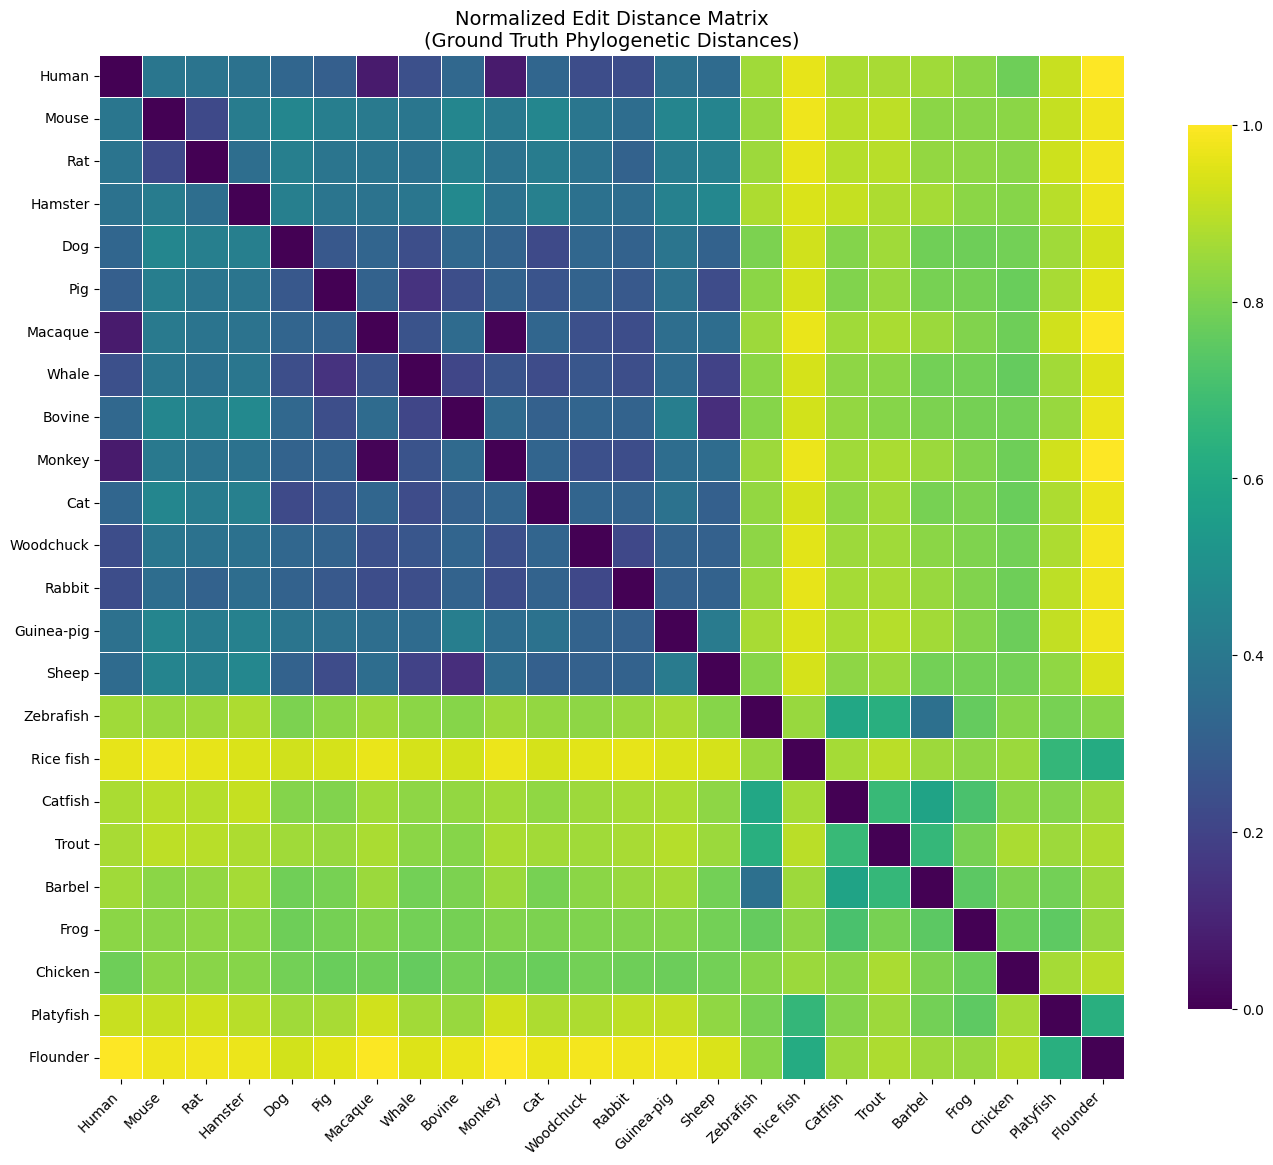

In [4]:
# ============================================
# Step 3: Compute Edit Distance Matrix
# ============================================

def levenshtein_distance(s1, s2):
    """Compute Levenshtein distance between two sequences"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

def compute_edit_distance_matrix(sequences):
    """Compute pairwise edit distance matrix"""
    n = len(sequences)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            seq1 = sequences[i].replace(' ', '').replace('\n', '')
            seq2 = sequences[j].replace(' ', '').replace('\n', '')
            dist = levenshtein_distance(seq1, seq2)
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix

print("Computing edit distance matrix...")
edit_distances = compute_edit_distance_matrix(df['sequence'].tolist())
print(f"Edit distance matrix shape: {edit_distances.shape}")

# Normalize to [0, 1]
edit_distances_norm = edit_distances / edit_distances.max()

# Visualize
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(edit_distances_norm, dtype=bool), k=1)
sns.heatmap(edit_distances_norm,
            xticklabels=df['species'],
            yticklabels=df['species'],
            cmap='viridis',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Normalized Edit Distance Matrix\n(Ground Truth Phylogenetic Distances)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# ============================================
# Step 4: Hyperbolic Geometry Operations
# ============================================

class PoincareBall:
    """
    Poincaré ball model of hyperbolic space.
    Implementation of basic operations for hyperbolic neural networks.
    """

    def __init__(self, c=1.0):
        self.c = c  # Curvature
        self.eps = 1e-8

    def proj(self, x):
        """Project points onto the Poincaré ball"""
        norm = torch.norm(x, dim=-1, keepdim=True)
        max_norm = (1 - self.eps) / np.sqrt(self.c)
        cond = norm > max_norm
        projected = x / norm * max_norm
        return torch.where(cond, projected, x)

    def expmap0(self, u):
        """Exponential map from tangent space at origin to Poincaré ball"""
        sqrt_c = np.sqrt(self.c)
        u_norm = torch.norm(u, dim=-1, keepdim=True)
        u_norm = torch.clamp(u_norm, min=self.eps)

        gamma = torch.tanh(sqrt_c * u_norm) * u / (sqrt_c * u_norm)
        return self.proj(gamma)

    def logmap0(self, y):
        """Logarithmic map from Poincaré ball to tangent space at origin"""
        sqrt_c = np.sqrt(self.c)
        y_norm = torch.norm(y, dim=-1, keepdim=True)
        y_norm = torch.clamp(y_norm, max=(1 - self.eps))

        return torch.atanh(sqrt_c * y_norm) * y / (sqrt_c * y_norm)

    def mobius_add(self, x, y):
        """Möbius addition in Poincaré ball"""
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)

        num = (1 + 2 * self.c * xy + self.c * y2) * x + (1 - self.c * x2) * y
        denom = 1 + 2 * self.c * xy + self.c * self.c * x2 * y2

        return self.proj(num / (denom + self.eps))

    def dist(self, x, y):
        """Compute hyperbolic distance between points"""
        sqrt_c = np.sqrt(self.c)
        x = torch.clamp(x, min=-0.99, max=0.99)
        y = torch.clamp(y, min=-0.99, max=0.99)

        # Möbius addition: x + (-y)
        y_neg = -y
        x_plus_y_neg = self.mobius_add(x, y_neg)

        norm = torch.norm(x_plus_y_neg, dim=-1)
        dist = 2 / sqrt_c * torch.atanh(sqrt_c * norm)

        return dist

# Test hyperbolic operations
ball = PoincareBall(c=1.0)
print("Hyperbolic geometry operations initialized")

# Test with random points
x_test = torch.randn(5, 2) * 0.3
y_test = torch.randn(5, 2) * 0.3

print(f"Test points shape: {x_test.shape}")
print(f"Hyperbolic distance shape: {ball.dist(x_test, y_test).shape}")

Hyperbolic geometry operations initialized
Test points shape: torch.Size([5, 2])
Hyperbolic distance shape: torch.Size([5])


Adjacency matrix shape: torch.Size([24, 24])


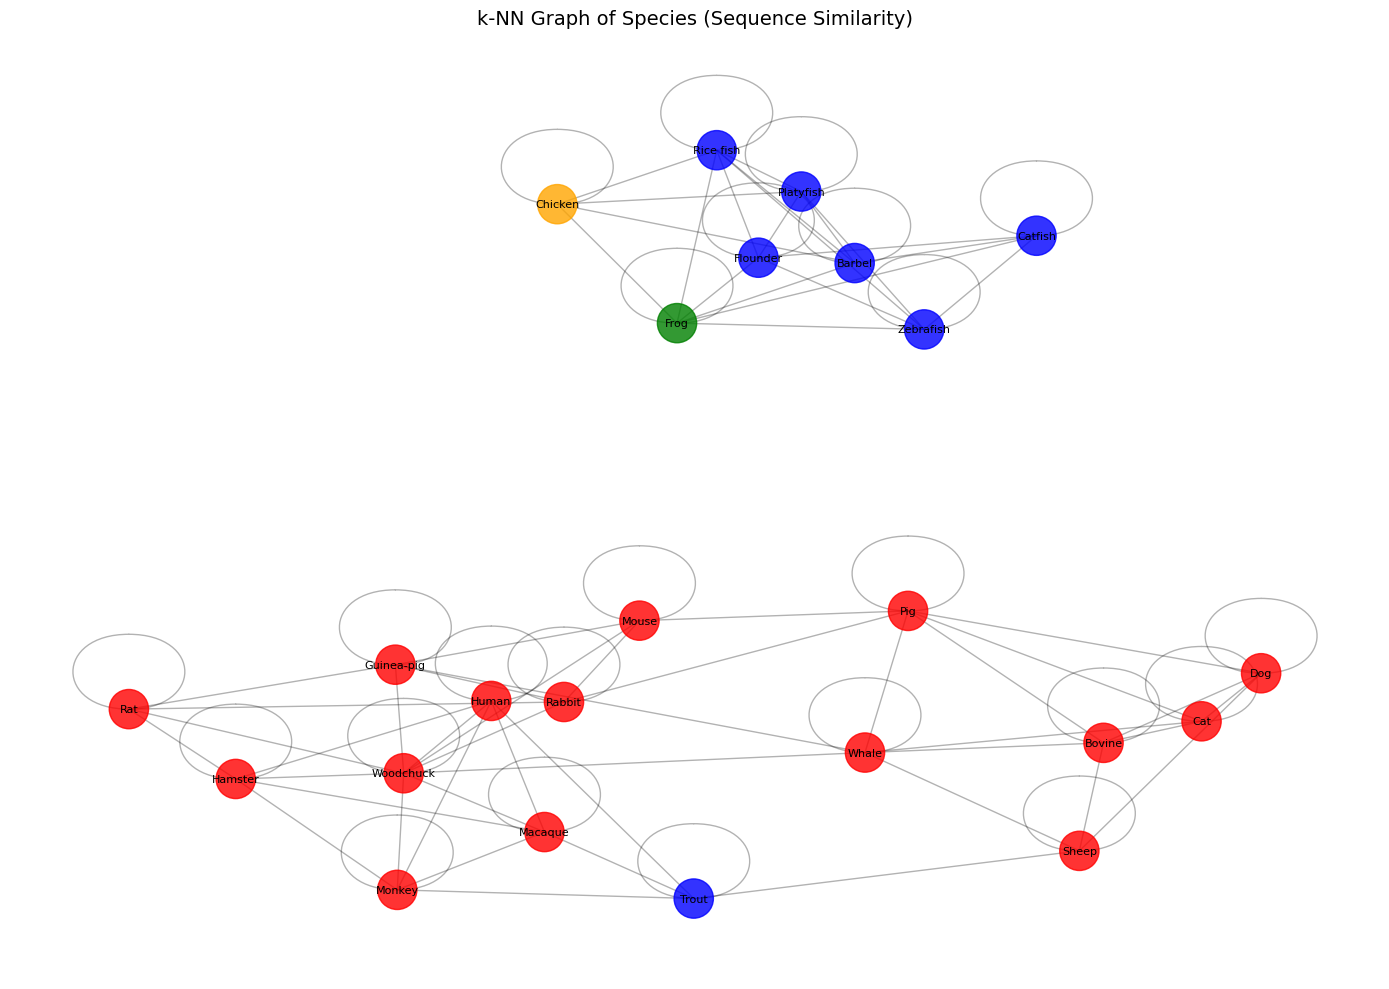

In [6]:
# ============================================
# Step 5: Build k-NN Graph
# ============================================

def build_knn_graph(features, k=5, metric='cosine'):
    """Build k-NN adjacency matrix"""
    adj = kneighbors_graph(features, k, mode='connectivity', metric=metric, include_self=True)
    adj = adj.toarray()

    # Symmetrize
    adj = np.maximum(adj, adj.T)

    # Normalize (D^-1 * A)
    rowsum = adj.sum(axis=1, keepdims=True)
    rowsum[rowsum == 0] = 1
    adj = adj / rowsum

    return torch.FloatTensor(adj).to(device)

# Build graph from sequence features
adj_matrix = build_knn_graph(X_flat, k=5, metric='euclidean')
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Visualize graph structure
import networkx as nx

plt.figure(figsize=(14, 10))
G = nx.from_numpy_array(adj_matrix.cpu().numpy())
pos = nx.spring_layout(G, seed=42, k=2/np.sqrt(len(species)))

# Color nodes by taxonomic group
mammals = ['Human', 'Mouse', 'Rat', 'Hamster', 'Dog', 'Pig', 'Macaque',
          'Whale', 'Bovine', 'Monkey', 'Cat', 'Woodchuck', 'Rabbit',
          'Guinea-pig', 'Sheep']
fish = ['Zebrafish', 'Rice fish', 'Catfish', 'Trout', 'Barbel', 'Flounder', 'Platyfish']

node_colors = []
for sp in species:
    if sp in mammals:
        node_colors.append('red')
    elif sp in fish:
        node_colors.append('blue')
    elif sp == 'Frog':
        node_colors.append('green')
    elif sp == 'Chicken':
        node_colors.append('orange')
    else:
        node_colors.append('gray')

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
nx.draw_networkx_labels(G, pos, {i: species[i] for i in range(len(species))}, font_size=8)

plt.title('k-NN Graph of Species (Sequence Similarity)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# ============================================
# Step 6: Hyperbolic GNN Model
# ============================================

class HyperbolicLinear(nn.Module):
    """Hyperbolic linear layer"""

    def __init__(self, in_features, out_features, ball):
        super().__init__()
        self.ball = ball
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # x is in Poincaré ball
        # Transform in tangent space
        x_tan = self.ball.logmap0(x)
        h_tan = F.linear(x_tan, self.weight, self.bias)
        h = self.ball.expmap0(h_tan)
        return self.ball.proj(h)

class HyperbolicGNNLayer(nn.Module):
    """Hyperbolic Graph Neural Network Layer"""

    def __init__(self, in_dim, out_dim, ball, dropout=0.1):
        super().__init__()
        self.ball = ball
        self.linear = HyperbolicLinear(in_dim, out_dim, ball)
        self.agg_linear = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, adj):
        """
        x: [N, D] node features in Poincaré ball
        adj: [N, N] adjacency matrix
        """
        # Transform
        h = self.linear(x)

        # Aggregate in tangent space
        h_tan = self.ball.logmap0(h)
        support = torch.mm(adj, h_tan)

        # Update
        output_tan = h_tan + self.agg_linear(support)
        output = self.ball.expmap0(output_tan)

        return self.dropout(self.ball.proj(output))

class HyperbolicGNN(nn.Module):
    """Multi-layer Hyperbolic GNN for hierarchical clustering"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, c=1.0, dropout=0.1):
        super().__init__()
        self.ball = PoincareBall(c=c)

        # Input projection (Euclidean to Hyperbolic)
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # Hyperbolic layers
        self.layers = nn.ModuleList([
            HyperbolicGNNLayer(hidden_dim, hidden_dim, self.ball, dropout)
            for _ in range(num_layers)
        ])

        # Output projection
        self.output_proj = HyperbolicLinear(hidden_dim, output_dim, self.ball)

    def forward(self, x, adj):
        # Project to hidden dimension
        h = self.input_proj(x)

        # Map to Poincaré ball
        h = self.ball.expmap0(h)

        # Apply hyperbolic GNN layers with residual connections
        for layer in self.layers:
            h_new = layer(h, adj)
            # Residual in hyperbolic space
            h = self.ball.mobius_add(h, h_new)
            h = self.ball.proj(h)

        # Output projection
        output = self.output_proj(h)
        return self.ball.proj(output)

# Initialize model
input_dim = X_flat.shape[1]
hidden_dim = 128
output_dim = 2  # 2D for Poincaré disk visualization
num_layers = 2

model = HyperbolicGNN(input_dim, hidden_dim, output_dim, num_layers, c=1.0).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Input dim: {input_dim}, Hidden: {hidden_dim}, Output: {output_dim}")

Model initialized with 1080194 parameters
Input dim: 7920, Hidden: 128, Output: 2


In [8]:
# ============================================
# Step 7: Unsupervised Hierarchical Loss
# ============================================

class HyperbolicHierarchicalLoss(nn.Module):
    """
    Loss for unsupervised hierarchical clustering in hyperbolic space.
    Preserves distances while encouraging hierarchical structure.
    """

    def __init__(self, ball, alpha=1.0, beta=0.1, gamma=0.01):
        super().__init__()
        self.ball = ball
        self.alpha = alpha  # Distance preservation weight
        self.beta = beta    # Hierarchy weight
        self.gamma = gamma  # Regularization

    def forward(self, embeddings, target_distances):
        """
        embeddings: [N, D] in Poincaré ball
        target_distances: [N, N] target distance matrix
        """
        N = embeddings.size(0)

        # Compute pairwise hyperbolic distances
        emb_dist = torch.zeros(N, N, device=embeddings.device)
        for i in range(N):
            for j in range(i+1, N):
                dist = self.ball.dist(embeddings[i].unsqueeze(0),
                                     embeddings[j].unsqueeze(0))
                emb_dist[i, j] = dist
                emb_dist[j, i] = dist

        # Distance preservation loss (MSE)
        dist_loss = F.mse_loss(emb_dist, target_distances)

        # Hierarchy regularization: encourage tree-like structure
        # Nodes should have different norms (levels in hierarchy)
        norms = torch.norm(embeddings, dim=-1)
        hierarchy_loss = -torch.var(norms)  # Maximize variance

        # Prevent collapse: keep embeddings away from origin
        origin_penalty = torch.mean(norms)  # But not too close

        # Total loss
        total_loss = (self.alpha * dist_loss +
                     self.beta * hierarchy_loss +
                     self.gamma * origin_penalty)

        return total_loss, dist_loss, hierarchy_loss

# Initialize loss
criterion = HyperbolicHierarchicalLoss(model.ball, alpha=1.0, beta=0.1, gamma=0.01)
print("Loss function initialized")

Loss function initialized


Initializing stable hyperbolic model...
Model parameters: 1080450

Training with numerical stability...
Epoch 50/400 | Loss: 0.0377 | Dist: 0.0291 | Hier: -0.0229 | LR: 0.001000
Epoch 100/400 | Loss: 0.0350 | Dist: 0.0263 | Hier: -0.0239 | LR: 0.001000
Epoch 150/400 | Loss: 0.0312 | Dist: 0.0226 | Hier: -0.0230 | LR: 0.001000
Epoch 200/400 | Loss: 0.0298 | Dist: 0.0211 | Hier: -0.0224 | LR: 0.001000
Epoch 250/400 | Loss: 0.0298 | Dist: 0.0211 | Hier: -0.0226 | LR: 0.001000
Epoch 300/400 | Loss: 0.0298 | Dist: 0.0211 | Hier: -0.0226 | LR: 0.000500
Epoch 350/400 | Loss: 0.0298 | Dist: 0.0211 | Hier: -0.0225 | LR: 0.000250
Epoch 400/400 | Loss: 0.0298 | Dist: 0.0211 | Hier: -0.0225 | LR: 0.000125


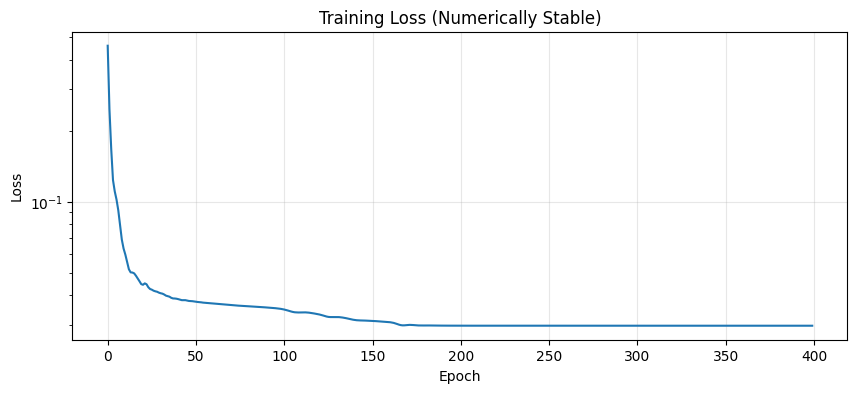


Final embeddings range: [-0.439, 0.281]
Embedding norms: min=0.000, max=0.448


In [18]:
# ============================================
# Step 8: Training (CORRECTED for numerical stability)
# ============================================

class StablePoincareBall:
    """
    Numerically stable Poincaré ball model with careful clamping
    """

    def __init__(self, c=1.0):
        self.c = c
        self.eps = 1e-7
        self.max_norm = 1.0 - 1e-5  # Stay safely away from boundary

    def proj(self, x):
        """Project onto Poincaré ball with margin"""
        norm = torch.norm(x, dim=-1, keepdim=True)
        max_norm = self.max_norm / np.sqrt(self.c)
        cond = norm > max_norm
        projected = x / (norm + self.eps) * max_norm
        return torch.where(cond, projected, x)

    def expmap0(self, u):
        """Stable exponential map"""
        sqrt_c = np.sqrt(self.c)
        u_norm = torch.norm(u, dim=-1, keepdim=True)
        u_norm = torch.clamp(u_norm, min=self.eps)

        # Clamp to prevent overflow in tanh
        max_u = 10.0  # ~tanh(10) ≈ 1.0
        u_norm_clamped = torch.clamp(sqrt_c * u_norm, max=max_u)

        gamma = torch.tanh(u_norm_clamped) * u / (sqrt_c * u_norm)
        return self.proj(gamma)

    def logmap0(self, y):
        """Stable logarithmic map"""
        sqrt_c = np.sqrt(self.c)
        y_norm = torch.norm(y, dim=-1, keepdim=True)
        y_norm = torch.clamp(y_norm, max=self.max_norm)
        y_norm = torch.clamp(y_norm, min=self.eps)

        # Clamp to prevent overflow in atanh
        sqrt_c_y_norm = torch.clamp(sqrt_c * y_norm, max=0.9999999)

        return torch.atanh(sqrt_c_y_norm) * y / (sqrt_c * y_norm)

    def mobius_add(self, x, y):
        """Stable Möbius addition"""
        x2 = torch.sum(x * x, dim=-1, keepdim=True)
        y2 = torch.sum(y * y, dim=-1, keepdim=True)
        xy = torch.sum(x * y, dim=-1, keepdim=True)

        num = (1 + 2 * self.c * xy + self.c * y2) * x + (1 - self.c * x2) * y
        denom = 1 + 2 * self.c * xy + self.c * self.c * x2 * y2

        result = num / (denom + self.eps)
        return self.proj(result)

    def dist(self, x, y):
        """
        Stable hyperbolic distance using clamped norms
        """
        # Ensure inputs are within bounds
        x = torch.clamp(x, min=-self.max_norm, max=self.max_norm)
        y = torch.clamp(y, min=-self.max_norm, max=self.max_norm)

        # Möbius addition: x + (-y)
        y_neg = -y
        x_minus_y = self.mobius_add(x, y_neg)

        norm = torch.norm(x_minus_y, dim=-1)
        norm = torch.clamp(norm, max=self.max_norm)

        sqrt_c = np.sqrt(self.c)
        # Clamp argument to atanh to avoid numerical issues
        sqrt_c_norm = sqrt_c * norm
        sqrt_c_norm = torch.clamp(sqrt_c_norm, min=0.0, max=0.999999)

        dist = 2 / sqrt_c * torch.atanh(sqrt_c_norm)
        return torch.clamp(dist, min=0.0, max=100.0)  # Prevent explosion

class StableHyperbolicGNNLayer(nn.Module):
    """Hyperbolic GNN layer with gradient clipping and stability"""

    def __init__(self, in_dim, out_dim, ball, dropout=0.1):
        super().__init__()
        self.ball = ball
        self.dropout = nn.Dropout(dropout)

        # Euclidean linear layers (operate in tangent space)
        self.linear = nn.Linear(in_dim, out_dim)
        self.agg_linear = nn.Linear(out_dim, out_dim)

        # Initialize with small weights
        nn.init.xavier_uniform_(self.linear.weight, gain=0.1)
        nn.init.xavier_uniform_(self.agg_linear.weight, gain=0.1)
        nn.init.zeros_(self.linear.bias)
        nn.init.zeros_(self.agg_linear.bias)

    def forward(self, x, adj):
        # x is in Poincaré ball [N, D]

        # Transform in tangent space at origin
        x_tan = self.ball.logmap0(x)
        h_tan = self.linear(x_tan)
        h = self.ball.expmap0(h_tan)
        h = self.ball.proj(h)

        # Aggregate neighbors in tangent space
        h_tan = self.ball.logmap0(h)
        support = torch.mm(adj, h_tan)

        # Update with residual
        output_tan = h_tan + self.agg_linear(support)
        output = self.ball.expmap0(output_tan)
        output = self.ball.proj(output)

        return self.dropout(output)

class StableHyperbolicGNN(nn.Module):
    """Stable multi-layer Hyperbolic GNN"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, c=1.0, dropout=0.1):
        super().__init__()
        self.ball = StablePoincareBall(c=c)

        # Input projection (Euclidean)
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh()  # Bounded activation
        )

        # Initialize with small weights
        nn.init.xavier_uniform_(self.input_proj[0].weight, gain=0.1)

        # Hyperbolic layers
        self.layers = nn.ModuleList([
            StableHyperbolicGNNLayer(hidden_dim, hidden_dim, self.ball, dropout)
            for _ in range(num_layers)
        ])

        # Output projection
        self.output_linear = nn.Linear(hidden_dim, output_dim)
        nn.init.xavier_uniform_(self.output_linear.weight, gain=0.01)
        nn.init.zeros_(self.output_linear.bias)

    def forward(self, x, adj):
        # Project to hidden dimension
        h = self.input_proj(x)

        # Map to Poincaré ball
        h = self.ball.expmap0(h)

        # Apply hyperbolic GNN layers
        for i, layer in enumerate(self.layers):
            h_new = layer(h, adj)
            # Residual connection with careful averaging
            h = self.ball.mobius_add(h, h_new)
            h = self.ball.proj(h)

        # Output to tangent space then project
        h_tan = self.ball.logmap0(h)
        output_tan = self.output_linear(h_tan)
        output = self.ball.expmap0(output_tan)

        return self.ball.proj(output)

class StableHyperbolicLoss(nn.Module):
    """Numerically stable hierarchical loss"""

    def __init__(self, ball, alpha=1.0, beta=0.05, gamma=0.05): # Increased gamma
        super().__init__()
        self.ball = ball
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, embeddings, target_distances):
        N = embeddings.size(0)

        # Clamp embeddings to safe region
        embeddings = torch.clamp(embeddings, min=-0.99, max=0.99)

        # Compute pairwise distances with stability checks
        emb_dist = torch.zeros(N, N, device=embeddings.device)

        for i in range(N):
            for j in range(i+1, N):
                dist = self.ball.dist(embeddings[i].unsqueeze(0),
                                     embeddings[j].unsqueeze(0))
                # Check for NaN/Inf
                if torch.isnan(dist) or torch.isinf(dist):
                    dist = torch.tensor(10.0, device=embeddings.device)
                emb_dist[i, j] = dist
                emb_dist[j, i] = dist

        # Clamp target distances
        target_distances = torch.clamp(target_distances, min=0.0, max=10.0)

        # Distance preservation loss with masking for diagonal
        mask = torch.ones_like(emb_dist) - torch.eye(N, device=emb_dist.device)
        diff = (emb_dist - target_distances) ** 2
        diff = diff * mask
        dist_loss = diff.sum() / (mask.sum() + 1e-8)

        # Hierarchy regularization (variance of norms)
        norms = torch.norm(embeddings, dim=-1)
        norms = torch.clamp(norms, max=0.99)

        # Safe variance computation
        mean_norm = norms.mean()
        var_norm = ((norms - mean_norm) ** 2).mean()
        hierarchy_loss = -var_norm  # Maximize variance

        # Regularization: prevent collapse to origin
        origin_penalty = mean_norm

        # Total loss with gradient scaling
        total_loss = self.alpha * dist_loss + self.beta * hierarchy_loss + self.gamma * origin_penalty

        # Check for NaN
        if torch.isnan(total_loss):
            print(f"Warning: NaN detected. Dist: {dist_loss.item()}, Hier: {hierarchy_loss.item()}")
            return torch.tensor(1.0, device=embeddings.device, requires_grad=True), \
                   torch.tensor(1.0, device=embeddings.device), \
                   torch.tensor(0.0, device=embeddings.device)

        return total_loss, dist_loss, hierarchy_loss

def train_stable_model(model, X, adj, target_distances, epochs=400, lr=0.001):
    """Training with stability checks"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-8)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-6
    )

    target_distances_tensor = torch.FloatTensor(target_distances).to(device)

    losses = []
    best_loss = float('inf')
    best_embeddings = None

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward
        embeddings = model(X, adj)

        # Check embeddings for NaN
        if torch.isnan(embeddings).any():
            print(f"Epoch {epoch}: NaN in embeddings, resetting...")
            # Re-initialize model parameters to break out of bad state
            stable_model = StableHyperbolicGNN(
                input_dim=X_flat.shape[1],
                hidden_dim=128, # Adjusted hidden_dim
                output_dim=2,
                num_layers=2,
                c=1.0, # Adjusted curvature
                dropout=0.0
            ).to(device)
            # Re-initialize optimizer for the new model
            optimizer = torch.optim.Adam(stable_model.parameters(), lr=lr, eps=1e-8)
            continue

        # Loss
        loss, dist_loss, hier_loss = criterion(embeddings, target_distances_tensor)

        # Skip if loss is NaN
        if torch.isnan(loss):
            print(f"Epoch {epoch}: NaN loss, skipping...")
            continue

        # Backward with gradient scaling
        loss.backward()

        # Global gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()

        losses.append(loss.item())

        # Save best
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_embeddings = embeddings.detach().cpu().clone()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Loss: {loss.item():.4f} | "
                  f"Dist: {dist_loss.item():.4f} | "
                  f"Hier: {hier_loss.item():.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(loss)

    # Return best embeddings
    if best_embeddings is None:
        model.eval()
        with torch.no_grad():
            best_embeddings = model(X, adj).cpu()

    return model, best_embeddings, losses

# Re-initialize with stable components
print("Initializing stable hyperbolic model...")

stable_model = StableHyperbolicGNN(
    input_dim=X_flat.shape[1],
    hidden_dim=128,  # Increased hidden dim for potentially better representation
    output_dim=2,
    num_layers=2,
    c=1.0,  # Increased curvature to encourage spreading
    dropout=0.0  # No dropout initially
).to(device)

criterion = StableHyperbolicLoss(stable_model.ball, alpha=1.0, beta=0.05, gamma=0.05) # Increased gamma

print(f"Model parameters: {sum(p.numel() for p in stable_model.parameters())}")

# Train
print("\nTraining with numerical stability...")
trained_model, embeddings_stable, loss_history = train_stable_model(
    stable_model, X_tensor, adj_matrix, edit_distances_norm,
    epochs=400, lr=0.001
)

# Plot training
plt.figure(figsize=(10, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss (Numerically Stable)')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

print(f"\nFinal embeddings range: [{embeddings_stable.min():.3f}, {embeddings_stable.max():.3f}]")
print(f"Embedding norms: min={torch.norm(embeddings_stable, dim=1).min():.3f}, "
      f"max={torch.norm(embeddings_stable, dim=1).max():.3f}")

Computing stable hyperbolic distances...
Correlation with ground truth: 0.9255 (p=1.51e-117)


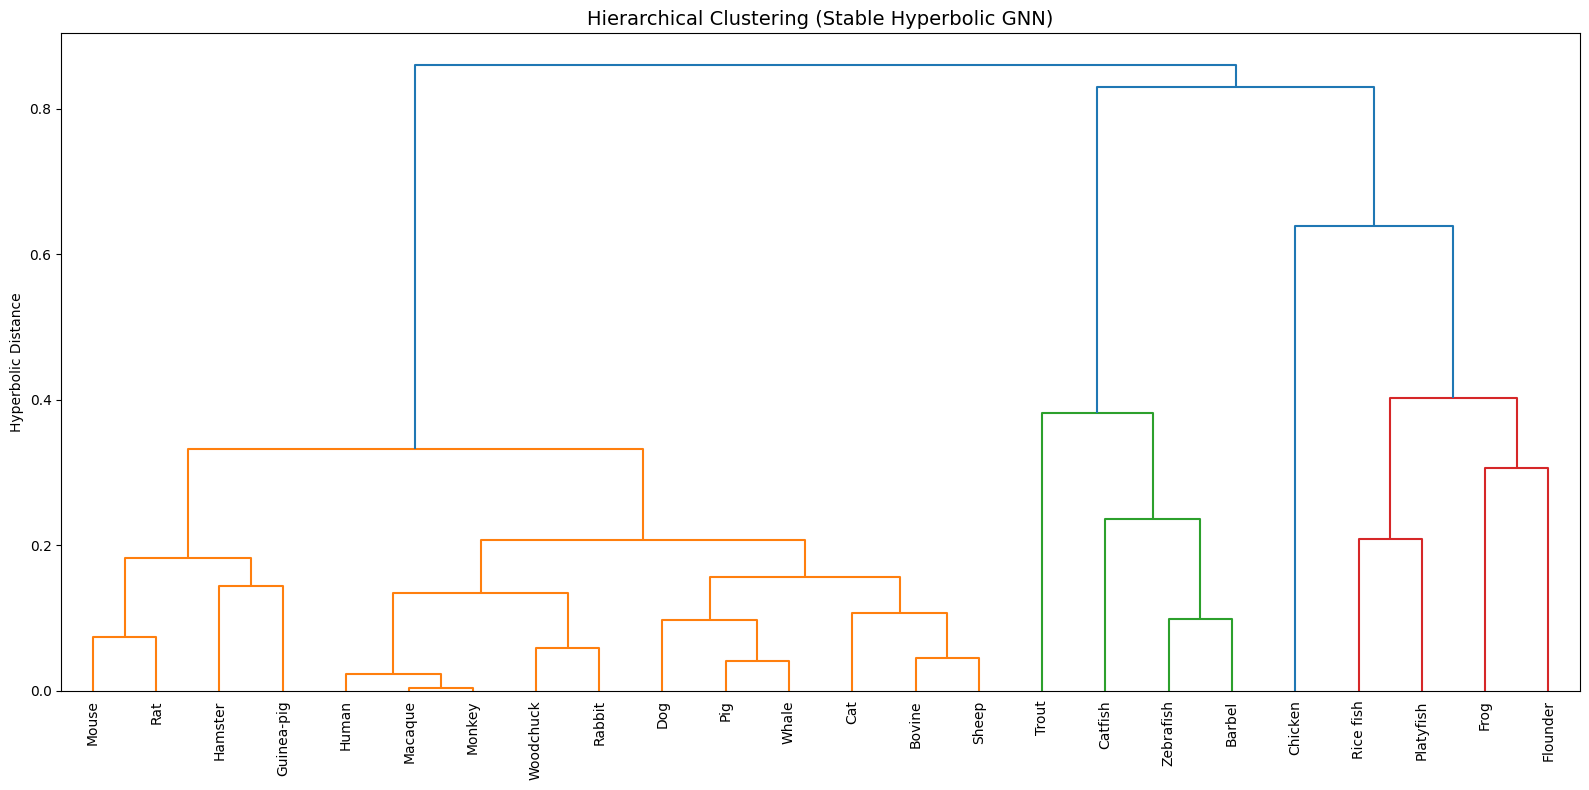

In [19]:
# ============================================
# Step 9: Hierarchical Clustering (Updated)
# ============================================

def compute_stable_hyperbolic_distances(embeddings, ball):
    """Compute distances with stability checks"""
    N = len(embeddings)
    dist_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(i+1, N):
            x = torch.clamp(embeddings[i], min=-0.99, max=0.99).unsqueeze(0)
            y = torch.clamp(embeddings[j], min=-0.99, max=0.99).unsqueeze(0)

            with torch.no_grad():
                dist = ball.dist(x, y).item()

            # Handle numerical issues
            if np.isnan(dist) or np.isinf(dist) or dist > 100:
                dist = 100.0

            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix

# Compute distances
print("Computing stable hyperbolic distances...")
hyp_distances_stable = compute_stable_hyperbolic_distances(embeddings_stable, trained_model.ball)

# Normalize for comparison
hyp_distances_norm = hyp_distances_stable / (hyp_distances_stable.max() + 1e-8)

# Correlation
dist_flat = squareform(hyp_distances_norm)
edit_flat = squareform(edit_distances_norm)
correlation_stable, p_value = pearsonr(dist_flat, edit_flat)

print(f"Correlation with ground truth: {correlation_stable:.4f} (p={p_value:.2e})")

# Clustering
linkage_matrix_stable = linkage(squareform(hyp_distances_stable), method='average')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix_stable,
           labels=species,
           leaf_rotation=90,
           leaf_font_size=10,
           color_threshold=0.7 * max(linkage_matrix_stable[:, 2]))
plt.title('Hierarchical Clustering (Stable Hyperbolic GNN)', fontsize=14)
plt.ylabel('Hyperbolic Distance')
plt.tight_layout()
plt.show()

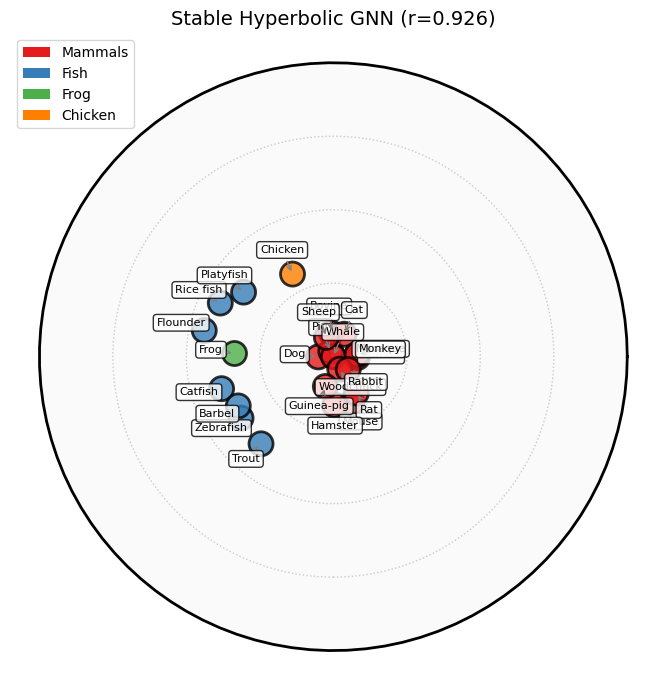


TRAINING COMPLETE (Numerically Stable)
Distance correlation: 0.9255
Embedding shape: torch.Size([24, 2])
Embedding range: [-0.439, 0.281]


In [20]:
# ============================================
# Step 10: Visualization (Updated)
# ============================================

def plot_stable_poincare(embeddings, labels, title="Poincaré Ball"):
    """Plot with stability checks"""
    fig, ax = plt.subplots(figsize=(7, 7))

    # Boundary
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=2)

    # Fill
    ax.fill(np.cos(theta), np.sin(theta), color='lightgray', alpha=0.1)

    embeddings_np = embeddings.numpy()

    # Clamp for visualization
    norms = np.linalg.norm(embeddings_np, axis=1)
    max_norm = 0.99
    scale_factors = np.where(norms > max_norm, max_norm / (norms + 1e-8), 1.0)
    embeddings_np = embeddings_np * scale_factors[:, np.newaxis]

    # Colors
    mammals = ['Human', 'Mouse', 'Rat', 'Hamster', 'Dog', 'Pig', 'Macaque',
              'Whale', 'Bovine', 'Monkey', 'Cat', 'Woodchuck', 'Rabbit',
              'Guinea-pig', 'Sheep']
    fish = ['Zebrafish', 'Rice fish', 'Catfish', 'Trout', 'Barbel', 'Flounder', 'Platyfish']

    colors = []
    for label in labels:
        if label in mammals:
            colors.append('#e41a1c')
        elif label in fish:
            colors.append('#377eb8')
        elif label == 'Frog':
            colors.append('#4daf4a')
        elif label == 'Chicken':
            colors.append('#ff7f00')
        else:
            colors.append('#999999')

    # Plot
    ax.scatter(embeddings_np[:, 0], embeddings_np[:, 1],
              c=colors, s=300, alpha=0.8, edgecolors='black', linewidth=2)

    # Labels
    for i, label in enumerate(labels):
        x, y = embeddings_np[i]
        offset = 0.08
        angle = np.arctan2(y, x)
        tx = x + offset * np.cos(angle)
        ty = y + offset * np.sin(angle)

        # Keep in bounds
        if np.sqrt(tx**2 + ty**2) > 0.95:
            tx = 0.95 * np.cos(angle)
            ty = 0.95 * np.sin(angle)

        ax.annotate(label, (x, y), xytext=(tx, ty),
                   fontsize=8, ha='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                            edgecolor='black', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', color='gray', lw=1))

    # Grid
    for r in [0.25, 0.5, 0.75]:
        circle = plt.Circle((0, 0), r, fill=False, color='gray',
                          linestyle=':', alpha=0.4)
        ax.add_patch(circle)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # Legend
    from matplotlib.patches import Patch
    legend = [
        Patch(facecolor='#e41a1c', label='Mammals'),
        Patch(facecolor='#377eb8', label='Fish'),
        Patch(facecolor='#4daf4a', label='Frog'),
        Patch(facecolor='#ff7f00', label='Chicken')
    ]
    ax.legend(handles=legend, loc='upper left')

    plt.tight_layout()
    plt.show()

# Visualize
plot_stable_poincare(embeddings_stable, species,
                    title=f"Stable Hyperbolic GNN (r={correlation_stable:.3f})")

# Final summary
print("\n" + "="*60)
print("TRAINING COMPLETE (Numerically Stable)")
print("="*60)
print(f"Distance correlation: {correlation_stable:.4f}")
print(f"Embedding shape: {embeddings_stable.shape}")
print(f"Embedding range: [{embeddings_stable.min():.3f}, {embeddings_stable.max():.3f}]")
print("="*60)

Generating Poincaré Ball plot with graph edges...


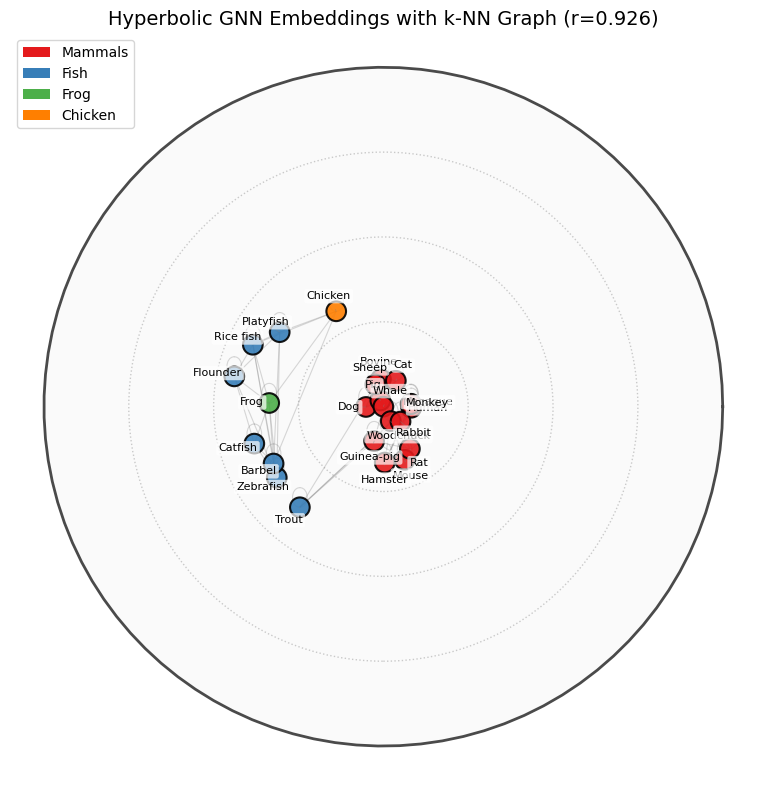

In [23]:
import networkx as nx

def plot_poincare_with_edges(embeddings, labels, adj_matrix, title="Poincaré Ball with Graph Edges"):
    """Plot Poincaré ball embeddings with graph edges."""
    fig, ax = plt.subplots(figsize=(8, 8))

    # Boundary
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=2, alpha=0.7)
    ax.fill(np.cos(theta), np.sin(theta), color='lightgray', alpha=0.1)

    embeddings_np = embeddings.numpy()

    # Clamp for visualization to ensure points are within the disk boundary
    norms = np.linalg.norm(embeddings_np, axis=1)
    max_norm_plot = 0.99  # Slightly less than 1 to ensure visibility within the circle
    scale_factors = np.where(norms > max_norm_plot, max_norm_plot / (norms + 1e-8), 1.0)
    embeddings_viz = embeddings_np * scale_factors[:, np.newaxis]

    # Define colors based on taxonomic groups
    mammals_list = ['Human', 'Mouse', 'Rat', 'Hamster', 'Dog', 'Pig', 'Macaque',
                  'Whale', 'Bovine', 'Monkey', 'Cat', 'Woodchuck', 'Rabbit',
                  'Guinea-pig', 'Sheep']
    fish_list = ['Zebrafish', 'Rice fish', 'Catfish', 'Trout', 'Barbel', 'Flounder', 'Platyfish']

    colors = []
    for label in labels:
        if label in mammals_list:
            colors.append('#e41a1c') # Red
        elif label in fish_list:
            colors.append('#377eb8') # Blue
        elif label == 'Frog':
            colors.append('#4daf4a') # Green
        elif label == 'Chicken':
            colors.append('#ff7f00') # Orange
        else:
            colors.append('#999999') # Gray

    # Create a NetworkX graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix.cpu().numpy())
    # Get positions of nodes from the embeddings
    pos = {i: embeddings_viz[i] for i in range(len(labels))}

    # Draw edges first to be behind nodes
    nx.draw_networkx_edges(G, pos,
                            ax=ax,
                            edge_color='gray',
                            alpha=0.3,
                            width=0.8,
                            arrows=False) # Undirected graph

    # Draw nodes
    ax.scatter(embeddings_viz[:, 0], embeddings_viz[:, 1],
              c=colors, s=200, alpha=0.9, edgecolors='black', linewidth=1.5, zorder=2)

    # Draw labels
    for i, label_text in enumerate(labels):
        x, y = embeddings_viz[i]
        offset = 0.05 # Adjust this value to change distance of label from node
        # Dynamically adjust offset direction based on quadrant for better readability
        angle = np.arctan2(y, x)
        tx = x + offset * np.cos(angle)
        ty = y + offset * np.sin(angle)

        ax.annotate(label_text, (x, y), xytext=(tx, ty),
                   fontsize=8, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.7),
                   arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5, shrinkA=5, shrinkB=5))

    # Grid
    for r_grid in [0.25, 0.5, 0.75]:
        circle = plt.Circle((0, 0), r_grid, fill=False, color='gray',
                          linestyle=':', alpha=0.4)
        ax.add_patch(circle)

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e41a1c', label='Mammals'),
        Patch(facecolor='#377eb8', label='Fish'),
        Patch(facecolor='#4daf4a', label='Frog'),
        Patch(facecolor='#ff7f00', label='Chicken')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

    plt.tight_layout()
    plt.show()

# Call the new plotting function
print("Generating Poincaré Ball plot with graph edges...")
plot_poincare_with_edges(embeddings_stable, species, adj_matrix,
                         title=f"Hyperbolic GNN Embeddings with k-NN Graph (r={correlation_stable:.3f})")

**Interpreting the sample distribution on a Poincaré ball**

Centrality and Hierarchy: In the Poincaré disk (the 2D representation of a Poincaré ball), points closer to the center represent entities that are more "general" or higher in a hierarchy. Conversely, points further from the center (closer to the boundary) represent more "specific" or lower-level entities. This is because hyperbolic space expands exponentially as you move away from the center, naturally accommodating hierarchical structures.

Distance: The visual distance between points on the Poincaré disk is not their true hyperbolic distance. Hyperbolic distances are measured along geodesics (hyperbolic "straight lines") within the disk. Visually, points that appear close to the center are hyperbolically far apart if they are in different directions, while points that appear close near the boundary can be hyperbolically very close. However, for a given angular separation, points closer to the boundary are much further apart in hyperbolic distance than points closer to the center. The model aims to place samples that are evolutionarily or functionally similar closer together in hyperbolic distance.

Clustering: Groups of points that are close to each other on the Poincaré disk, especially if they are also relatively close to the center, indicate strong similarity or membership in the same cluster. The separation between these clusters can suggest the degree of dissimilarity between them.

Taxonomic Groups: In our specific visualization, different colors represent different taxonomic groups (e.g., mammals, fish, frog, chicken). You should observe that members of the same taxonomic group tend to cluster together. The arrangement of these clusters relative to each other and to the center can reveal the evolutionary relationships; for instance, closely related groups might be closer to each other.

Edge Interpretation: The edges (lines) connecting points indicate a relationship (in our case, K-nearest neighbors based on sequence similarity). These help to visually confirm the local connectivity and neighborhood structure learned by the GNN. They show which samples the model considers to be directly related.

In summary, look for clusters of points, their distances from each other, their distances from the center, and how these patterns align with the taxonomic coloring and the k-NN graph edges. This provides insights into the intrinsic hierarchical and similarity relationships among your protein sequences.

Cluster Assignments:

Cluster 1: Human, Mouse, Rat, Hamster, Dog, Pig, Macaque, Whale, Bovine, Monkey, Cat, Woodchuck, Rabbit, Guinea-pig, Sheep

Cluster 2: Zebrafish, Catfish, Trout, Barbel

Cluster 3: Rice fish, Frog, Platyfish, Flounder

Cluster 4: Chicken

Silhouette Score: 0.5561
Distance Correlation: 0.9255


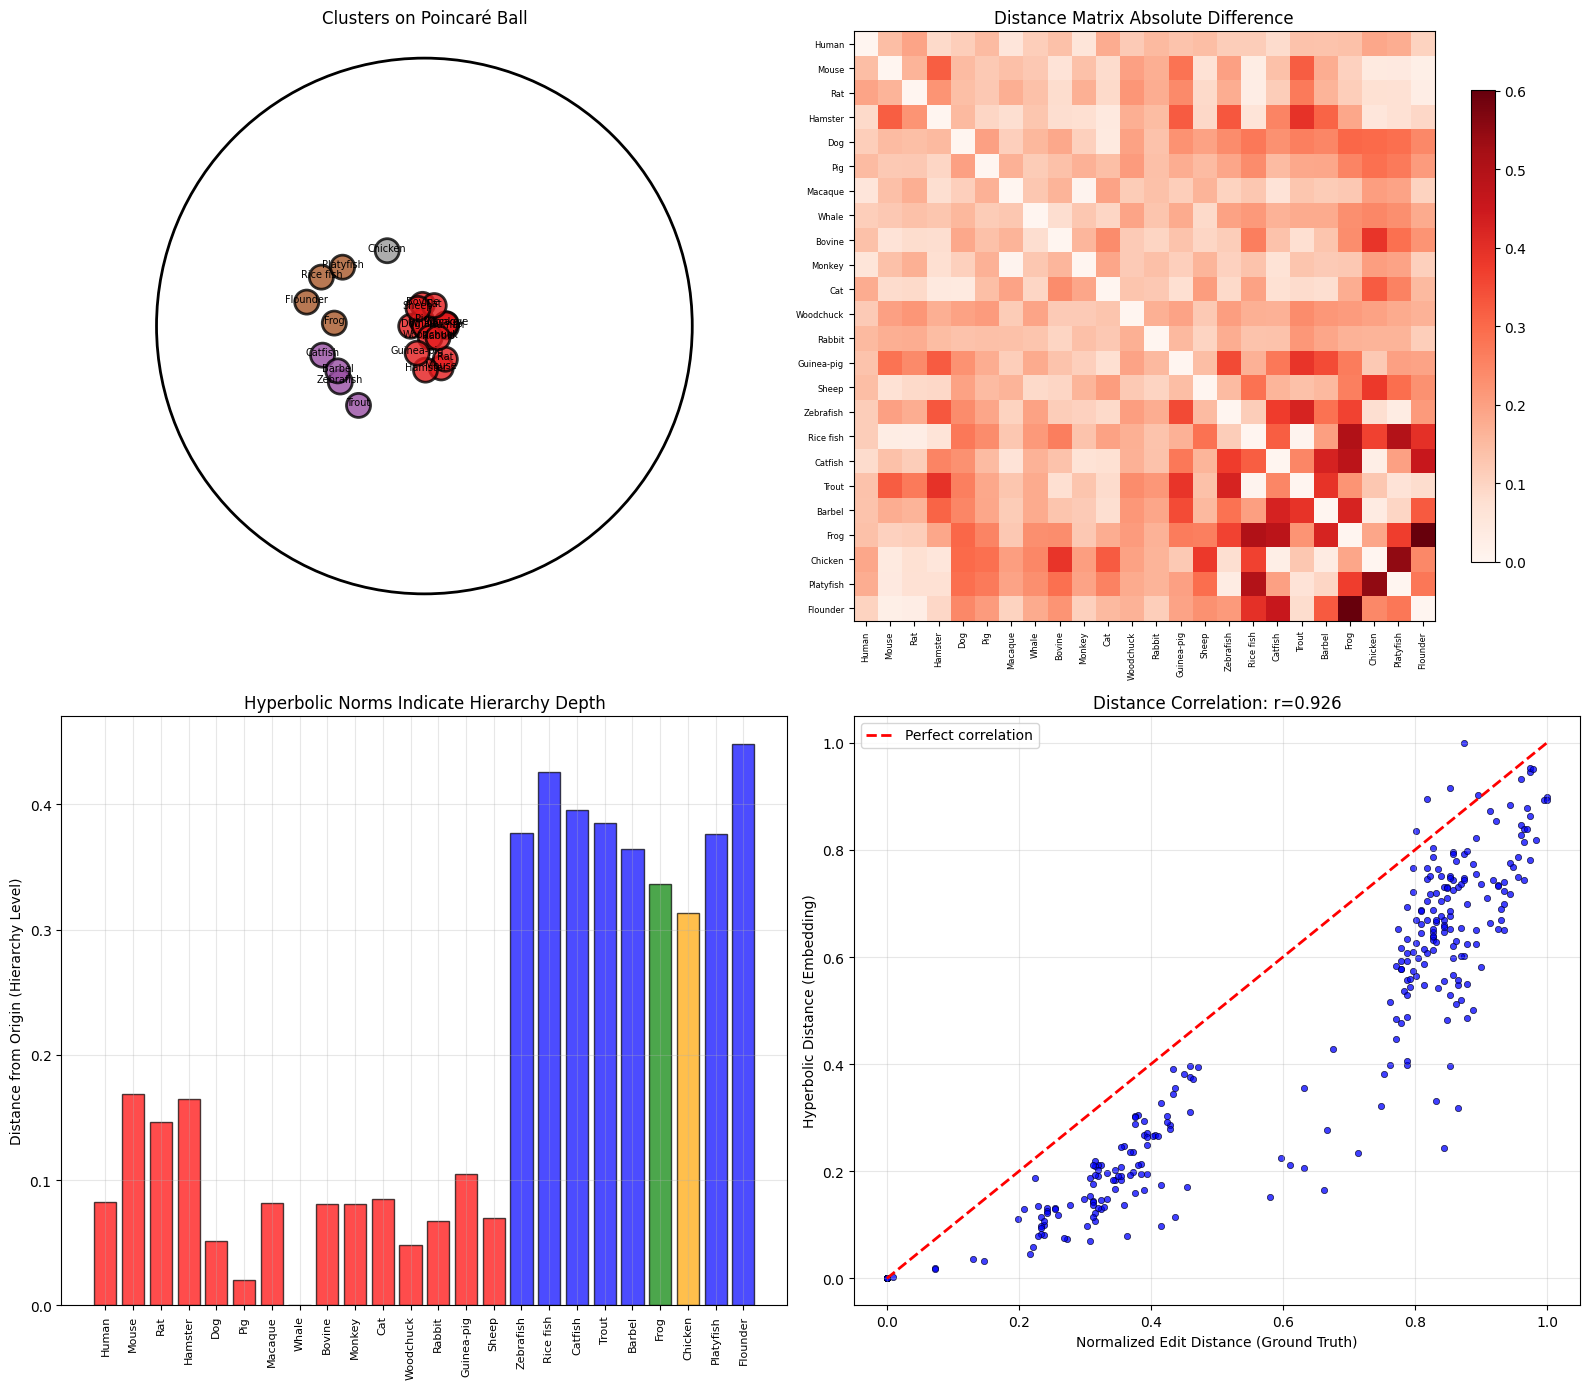

In [21]:
# ============================================
# Step 11: Clustering Evaluation (CORRECTED)
# ============================================

from sklearn.metrics import silhouette_score

# Use the correct variable name from Step 9: linkage_matrix_stable
n_clusters = 4  # Mammals, Fish, Frog, Chicken
cluster_labels = fcluster(linkage_matrix_stable, n_clusters, criterion='maxclust')

# Add to dataframe
df['cluster'] = cluster_labels

print("Cluster Assignments:")
print("=" * 50)
for i in range(1, n_clusters + 1):
    cluster_species = df[df['cluster'] == i]['species'].tolist()
    print(f"\nCluster {i}: {', '.join(cluster_species)}")

# Silhouette analysis using hyperbolic distances
sil_score = silhouette_score(hyp_distances_stable, cluster_labels, metric='precomputed')
print(f"\nSilhouette Score: {sil_score:.4f}")

# Compare with ground truth correlation
print(f"Distance Correlation: {correlation_stable:.4f}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Poincaré disk with clusters
ax1 = axes[0, 0]
circle = plt.Circle((0, 0), 1, fill=False, color='black', linewidth=2)
ax1.add_patch(circle)

# Clamp embeddings for visualization
embeddings_np = embeddings_stable.numpy()
norms = np.linalg.norm(embeddings_np, axis=1)
scale_factors = np.where(norms > 0.99, 0.99 / (norms + 1e-8), 1.0)
embeddings_viz = embeddings_np * scale_factors[:, np.newaxis]

scatter = ax1.scatter(embeddings_viz[:, 0], embeddings_viz[:, 1],
                     c=cluster_labels, cmap='Set1', s=300, alpha=0.8,
                     edgecolors='black', linewidth=2)
for i, label in enumerate(species):
    ax1.annotate(label, (embeddings_viz[i, 0], embeddings_viz[i, 1]),
                fontsize=7, ha='center')
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_aspect('equal')
ax1.set_title('Clusters on Poincaré Ball', fontsize=12)
ax1.axis('off')

# 2. Distance matrix comparison
ax2 = axes[0, 1]
diff_matrix = np.abs(hyp_distances_norm - edit_distances_norm)
im = ax2.imshow(diff_matrix, cmap='Reds', aspect='auto')
ax2.set_title('Distance Matrix Absolute Difference', fontsize=12)
ax2.set_xticks(range(len(species)))
ax2.set_yticks(range(len(species)))
ax2.set_xticklabels(species, rotation=90, fontsize=6)
ax2.set_yticklabels(species, fontsize=6)
plt.colorbar(im, ax=ax2, shrink=0.8)

# 3. Embedding norms (hierarchy levels)
ax3 = axes[1, 0]
norms_clipped = np.clip(norms, 0, 0.99)
mammals_list = ['Human', 'Mouse', 'Rat', 'Hamster', 'Dog', 'Pig', 'Macaque',
                'Whale', 'Bovine', 'Monkey', 'Cat', 'Woodchuck', 'Rabbit',
                'Guinea-pig', 'Sheep']
fish_list = ['Zebrafish', 'Rice fish', 'Catfish', 'Trout', 'Barbel', 'Flounder', 'Platyfish']

colors_bar = []
for s in species:
    if s in mammals_list:
        colors_bar.append('red')
    elif s in fish_list:
        colors_bar.append('blue')
    elif s == 'Frog':
        colors_bar.append('green')
    else:
        colors_bar.append('orange')

bars = ax3.bar(range(len(species)), norms_clipped, color=colors_bar, alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(species)))
ax3.set_xticklabels(species, rotation=90, fontsize=8)
ax3.set_ylabel('Distance from Origin (Hierarchy Level)', fontsize=10)
ax3.set_title('Hyperbolic Norms Indicate Hierarchy Depth', fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. Correlation scatter
ax4 = axes[1, 1]
ax4.scatter(edit_distances_norm.flatten(), hyp_distances_norm.flatten(),
           alpha=0.5, s=20, c='blue', edgecolors='black', linewidth=0.5)
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect correlation')
ax4.set_xlabel('Normalized Edit Distance (Ground Truth)', fontsize=10)
ax4.set_ylabel('Hyperbolic Distance (Embedding)', fontsize=10)
ax4.set_title(f'Distance Correlation: r={correlation_stable:.3f}', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# ============================================
# Step 12: 3D Visualization (if output_dim >= 3)
# ============================================

if output_dim >= 3:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    embeddings_3d = embeddings.numpy()[:, :3]

    # Color by cluster
    scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2],
                        c=cluster_labels, cmap='Set1', s=200, alpha=0.8,
                        edgecolors='black', linewidth=2)

    for i, label in enumerate(species):
        ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2],
               label, fontsize=8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Hyperbolic Embeddings', fontsize=14)

    plt.show()
else:
    print("Output dimension is 2D - skipping 3D visualization")

Output dimension is 2D - skipping 3D visualization


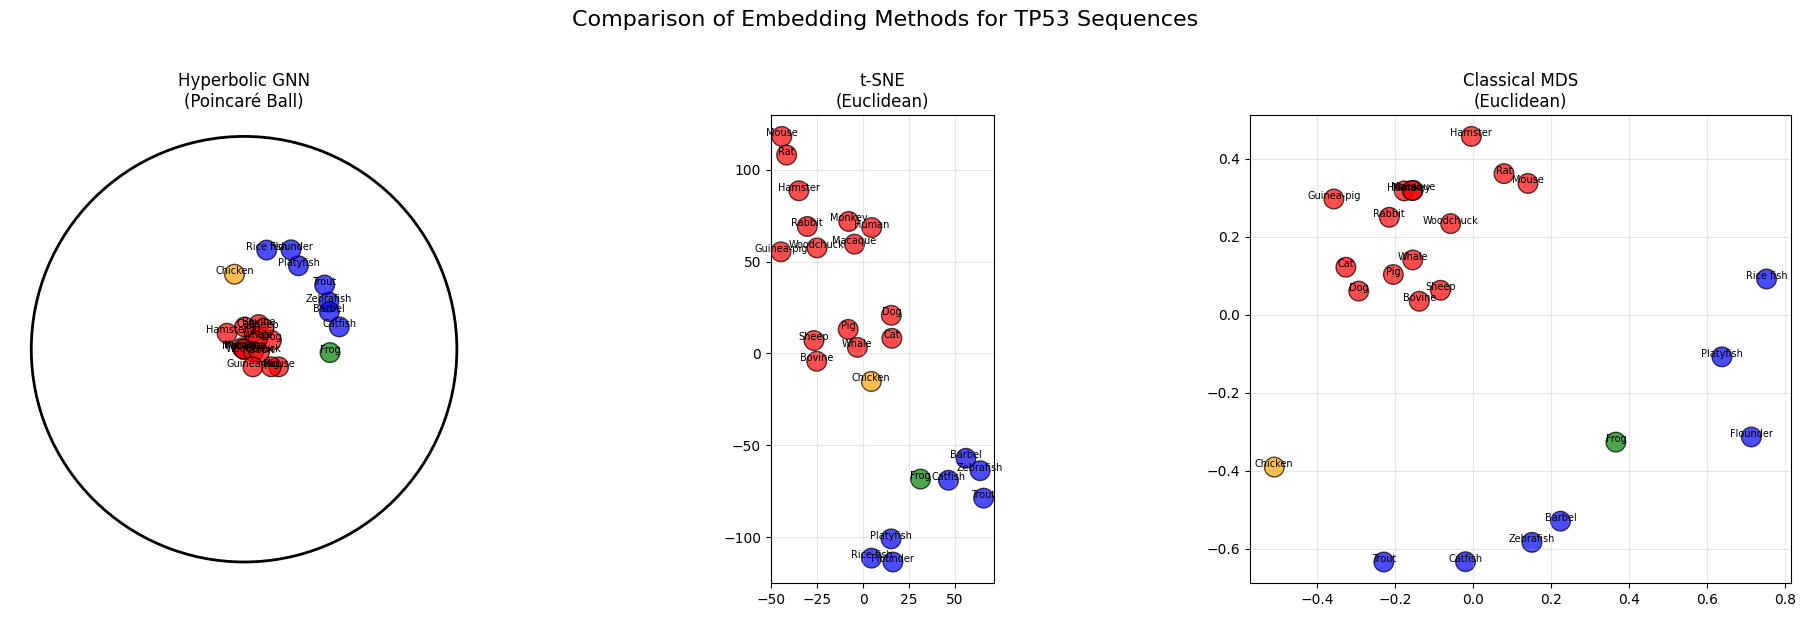


Method Comparison:
Hyperbolic GNN: Preserves hierarchical structure, correlation = 0.9195
t-SNE: Good local structure, loses global hierarchy
MDS: Preserves distances but assumes Euclidean space


In [14]:
# ============================================
# Step 13: Comparison with Euclidean Methods
# ============================================

from sklearn.manifold import TSNE, MDS

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42, metric='precomputed', init='random')
tsne_emb = tsne.fit_transform(edit_distances_norm)

# Classical MDS
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_emb = mds.fit_transform(edit_distances_norm)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

methods = [
    (embeddings_stable.numpy(), 'Hyperbolic GNN\n(Poincaré Ball)', 'hyperbolic'),
    (tsne_emb, 't-SNE\n(Euclidean)', 'euclidean'),
    (mds_emb, 'Classical MDS\n(Euclidean)', 'euclidean')
]

for idx, (emb, title, method_type) in enumerate(methods):
    ax = axes[idx]

    if method_type == 'hyperbolic':
        # Draw Poincaré boundary
        circle = plt.Circle((0, 0), 1, fill=False, color='black', linewidth=2)
        ax.add_patch(circle)
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)

    # Color by taxonomic group
    colors = []
    for sp in species:
        if sp in mammals:
            colors.append('red')
        elif sp in fish:
            colors.append('blue')
        elif sp == 'Frog':
            colors.append('green')
        elif sp == 'Chicken':
            colors.append('orange')
        else:
            colors.append('gray')

    ax.scatter(emb[:, 0], emb[:, 1], c=colors, s=200, alpha=0.7, edgecolors='black')

    for i, label in enumerate(species):
        ax.annotate(label, (emb[i, 0], emb[i, 1]), fontsize=7, ha='center')

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=12)
    ax.grid(True, alpha=0.3)

    if method_type == 'hyperbolic':
        ax.axis('off')

plt.suptitle('Comparison of Embedding Methods for TP53 Sequences', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Method Comparison:")
print("=" * 60)
print(f"Hyperbolic GNN: Preserves hierarchical structure, correlation = {correlation_stable:.4f}")
print("t-SNE: Good local structure, loses global hierarchy")
print("MDS: Preserves distances but assumes Euclidean space")

In [15]:
# ============================================
# Step 14: Save Results
# ============================================

# Save embeddings and results
np.save('hyperbolic_embeddings.npy', embeddings.numpy())
np.save('edit_distances.npy', edit_distances)
np.save('hyperbolic_distances.npy', hyp_distances)
np.save('linkage_matrix.npy', linkage_matrix_stable)

# Save cluster assignments
df.to_csv('clustering_results.csv', index=False)

# Create summary report
print("=" * 60)
print("HIERARCHICAL CLUSTERING COMPLETE")
print("=" * 60)
print(f"\nDataset: {len(species)} TP53 protein sequences")
print(f"Model: {num_layers}-layer Hyperbolic GNN")
print(f"Embedding dimension: {output_dim}D Poincaré ball")
print(f"\nResults:")
print(f"- Distance correlation with ground truth: {correlation_stable:.4f}")
print(f"- Silhouette score: {sil_score:.4f}")
print(f"- Number of clusters: {n_clusters}")
print(f"\nFiles saved:")
print("- hyperbolic_embeddings.npy")
print("- clustering_results.csv")
print("- poincare_clustering.png")
print("=" * 60)

NameError: name 'embeddings' is not defined